- 군집 (clustering) 
- 이상치 탐지
- 밀도 추정

먼저 k-평균과 DBSCAN 을 사용해 군집부터 시작해보자. 그 다음 가우시안 혼합 모델을 설명하고 어떻게 이를 밀도 추정, 군집, 이상치 탐지에 사용할 수 있는지 알아보자.

# 9.1 군집

알고리즘이 다르면 다른 종류의 클러스터를 감지한다. 예를 들어 어떤 알고리즘은 센트로이드라는 특정 포인트를 중심으로 모인 샘플을 찾는다. 또 어떤 알고리즘은 샘플이 밀집되어 연속된 영역을 찾는다.

## 9.1.0 필요한 라이브러리

In [ ]:
import sklearn
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

## 9.1.1 k-평균

In [ ]:
# 예제 데이터 생성
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [ ]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

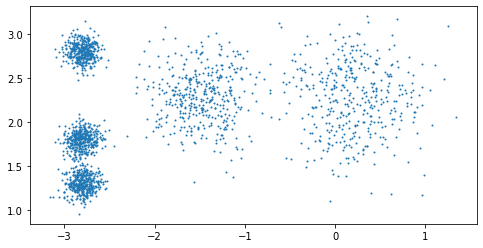

In [ ]:
# 위의 데이터를 시각화
# 산점도 함수
def plot_clusters(X, y=None):
  plt.scatter(X[:,0], X[:,1], c=y, s=1)

# 시각화
plt.figure(figsize=(8,4))
plot_clusters(X)
plt.show()

In [ ]:
# k-평균 알고리즘 훈련
# k-평균 알고리즘은 각 클러스터의 중심을 찾고 가장 가까운 클러스터에 샘플을 할당.
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

- 먼저 알고리즘이 찾을 클러스터의 개수를 지정해준다. (예제에서는 k=5)

- 각 샘플은 다섯 개의 클러스터 중 하나에 할당된다. 즉, 군집에서 각 샘플의 레이블은 알고리즘이 샘플에 할당한 클러스터 인덱스이다.

In [ ]:
y_pred

array([3, 2, 1, ..., 0, 1, 2], dtype=int32)

In [ ]:
# 알고리즘이 찾은 센트로이드 확인
kmeans.cluster_centers_

array([[-2.79290307,  2.79641063],
       [ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348]])

In [ ]:
# 클러스터의 결정경계를 보로노이 다이어그램으로 확인.
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)
    
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

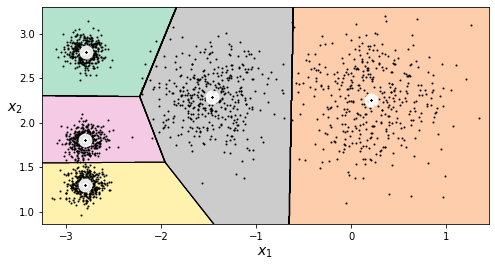

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

hard clustering 은 샘플을 하나의 클러스터에 할당하는 방식을 의미하며, soft clustering은 클러스커마다 샘플에 점수를 부여하는 방식이다. 점수는 샘플과 센트로이드 사이의 거리가 될 수 있다.

### 알고리즘의 원리

- 처음에는 센트로이드를 랜덤하게 선정한다. 그 다음 샘플에 레이블을 할당하고 센트로이드를 업데이트하는 방식을 반복한다.

- 위의 업데이트는, 센트로이드에 변화가 없을 때까지 진행되며 제한된 횟수 안에 센트로이드가 수렴하는 것을 보장한다.

- 이 알고리즘의 계산 복잡도는 일반적으로 샘플 개수 m, 클러스터 개수 k, 차원 개수 n에 선형적이다. 데이터가 군집할 수 있는 구조를 가질 때만 효과적이며 그렇지 않으면, 계산 복잡도는 샘플 개수의 지수적으로 증가한다.

### 계산 복잡도

이 알고리즘의 계산 복잡도는 일반적으로 샘플 개수, 클러스터 개수, 차원 개수에 선형적이다. 하지만 데이터가 군집할 수 있는 구조를 가질 때 같은 조건이다.

### k-평균의 변동성

원래 k-평균 알고리즘에서는 센트로이드가 그냥 랜덤하게 초기화되고 알고리즘은 단순히 한번씩 반복하여 점차 센트로이드를 개선시킨다. 하지만 이 방식의 문제점은 k-평균을 여러 번 실행하였을 때의 결과가 다를 수 있다는 단점이 있다.

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)

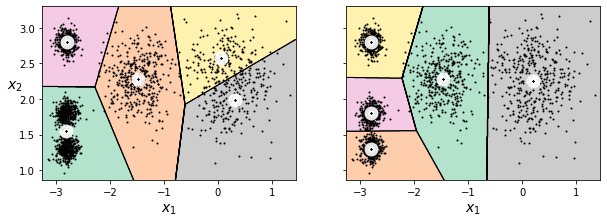

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)
plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2)
plt.show()

ㅇ러한 문제를 해결하는 방법은 미리 학습한 알고리즘에서 괜찮은 센트로이드를 리스트로 만들어 넘파이 배열을 지정하고 init 매개변수에 넘겨주는 것이다. 

또 다른 방법은 랜덤 초기화를 다르게 하여 여러 번 알고리즘을 수행하고 가장 좋은 솔루션을 선택하는 것이다.

### inertia

inertia 지표는 각 샘플과 센트로이드 사이의 거리를 측정하여 모델의 대략적인 성능을 확인한다.

In [ ]:
kmeans.inertia_

211.5985372581684

In [ ]:
# score() 메서드는 음의 inertia 를 반환한다.
kmeans.score(X)

-211.59853725816836

### 다중 초기화

변동성 이슈를 해결하는 한 방법은 단순히 K-평균 알고리즘을 랜덤 초기화를 다르게 하여 여러 번 실행하고 가장 작은 inertia를 만드는 솔루션을 선택한다.

In [ ]:
# n_init 매개변수 설정 -> 설정값만큼 알고리즘 반복, minimum inertia 모델 선택
kemans_rnd_10_inits = KMeans(n_clusters=5, init='random', n_init=10,
                             algorithm='full', random_state=2)
kemans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

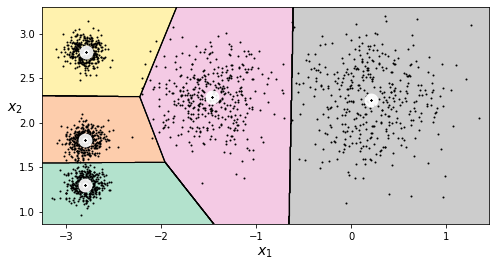

In [ ]:
# 미리 만들어둔 함수로 시각화
plt.figure(figsize=(8,4))
plot_decision_boundaries(kemans_rnd_10_inits, X)
plt.show()

### k-평균 속도 개선

- 삼각 부등식 사용(3의 포인트 a,b,c 가 있을 때 거리 ac 는 항상 ac <= ab + bc 를 만족) 그리고 샘플과 센트로이드 사이 거리의 최솟값과 최댓값을 유지한다.

- algorithm = "elkan" 으로 변경.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

50 loops, best of 5: 63.9 ms per loop


In [ ]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

50 loops, best of 5: 38.1 ms per loop


### 미니배치 k-평균

사이킷런은 미니배치를 지원하는 k-평균 방식도 지원한다.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [ ]:
minibatch_kmeans.inertia_

211.65239850433215

데이터셋이 메모리에 다 들어가지 못하면 가장 간단한 방법은 점진적 PCA에서 했던 것처럼 memmap 클래스를 사용하는 것이다.

https://github.com/rickiepark/handson-ml2/blob/master/09_unsupervised_learning.ipynb

In [ ]:
# mnist 데이터로 memmap 클래스 이용해보기
import urllib.request
from sklearn.datasets import fetch_openml

In [ ]:
mnist = fetch_openml('mnist_784', version=1)
type(mnist)

sklearn.utils.Bunch

### mnist_784 데이터셋에 대해

https://teddylee777.github.io/scikit-learn/scikit-learn-dataset

빌트인 데이터셋은 sklearn.utils.Bunch 라는 자료구조를 이용한다. key-value 형식으로 구성되어 있으며 dict와 유사.

공통 키는 다음과 같다.

- data: 샘플 데이터, numpy array
- target : label 데이터, numpy array
- feature_names : feature 데이터의 이름
- target_names: label 데이터의 이름

In [ ]:
import numpy as np
mnist.target = mnist.target.astype(np.int64)

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42
)

### memmap 에 대해서

대용량 numpy를 다루다보면 memory가 가득차는 경우가 발생한다. memmap 을 이용하면 속도는 조금 느리더라도 memory는 적게 쓰고 디스크를 이용할 수 있다.

In [ ]:
# memmap 에 데이터를 기록한다.
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
minibatch_kmeans = MiniBatchKMeans(
      n_clusters=10, batch_size=10, random_state=42
)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

In [ ]:
# 배치를 로드하는 함수를 만들어서 사용해보기
def load_next_batch(batch_size):
  # what is X ?
  return X[np.random.choice(len(X), batch_size, replace=False)]

In [ ]:
# 한 번에 하나의 배치를 모델에 주입하여 훈련할 수 있으며 여러번 초기화를 수행
# 이너셔가 가장 낮은 모델 선택
np.random.seed(42)

In [ ]:
k = 5
n_init = 10
n_iterations = 100
batch_size= 100
init_size = 500
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
  minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
  X_init = load_next_batch(init_size)
  minibatch_kmeans.partial_fit(X_init)

  minibatch_kmeans.sum_inertia_ = 0
  for iteration in range(n_iterations):
    X_batch = load_next_batch(batch_size)
    minibatch_kmeans.partial_fit(X_batch)
    if iteration >= n_iterations - evaluate_on_last_n_iters:
      minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
    
if (best_kmeans is None or minibatch_kmeans.sum_inertia_ < best.kmeans.sum_inertia_):
  best_kmeans = minibatch_kmeans

In [ ]:
best_kmeans.score(X)

-219.65435526023145

In [ ]:
# k-평균 알고리즘과 미니배치 k-평균 알고리즘 시간 비교
%time KMeans(n_clusters=5, random_state=42).fit(X)

CPU times: user 599 ms, sys: 5.88 ms, total: 605 ms
Wall time: 598 ms


KMeans(n_clusters=5, random_state=42)

In [ ]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

The slowest run took 28.74 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 16 ms per loop


### 최적의 클러스터 개수 찾기

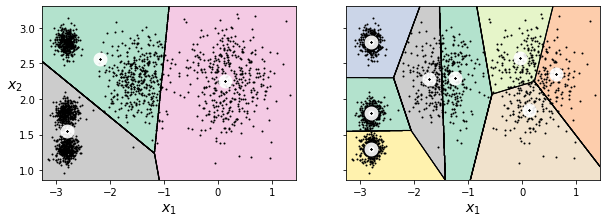

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8)
plt.show()

In [ ]:
# 각 inertia 확인
print(kmeans_k3.inertia_)
print(kmeans_k8.inertia_)

653.216719002155
119.11983416102879


클러스터 개수에 대한 기준을 찾아보자.

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

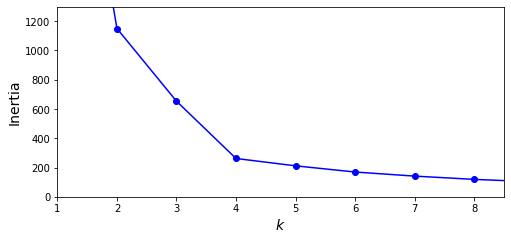

In [ ]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
plt.show()

클러스터 개수가 4 이상이면 괜찮은 결과를 얻을 수 있다.

적합한 클러스터 개수를 찾는 또 다른 방법은 모든 샘플에 대한 실루엣 계수의 평균인 실루엣 점수를 이용하는 방법이다.

한 샘플의 실루엣 계수는 다음과 같다.
```
a = 같은 클러스터에 있는 다른 샘플까지의 평균 거리
b = 가장 가까운 클러스터까지 평균거리

실루엣 계수 = (b - a) / max(a,b)
```

실루엣 계수는 -1 ~ +1 사이의 값을 가지며, +1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터 안에 잘 있다는 것을 의미한다. 

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [ ]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

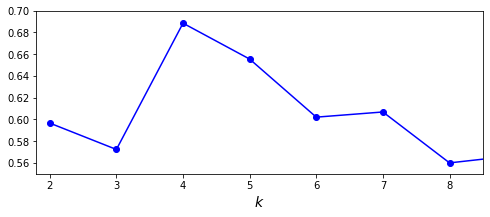

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

모든 샘플의 실루엣 계수를 할당된 클러스터와 실루엣 값으로 정렬하여 그리면 훨씬 많은 정보를 얻을 수 있으며 이를 실루엣 다이어그램이라고 한다.

### k-평균의 한계

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

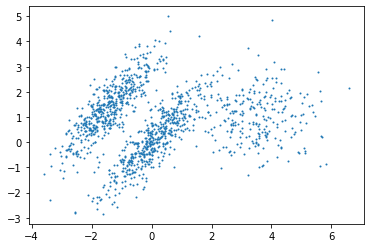

In [ ]:
plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

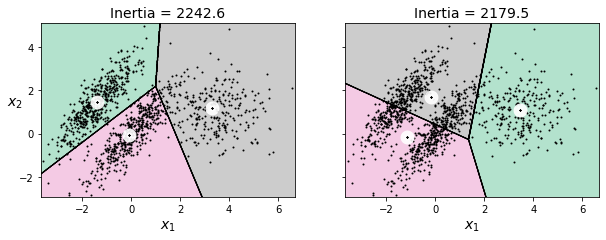

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)


plt.show()

## 9.1.3 군집을 사용한 이미지 분할

In [ ]:
import os
from sklearn.datasets import make_blobs
import urllib
from sklearn.cluster import KMeans

In [ ]:
PROJECT_ROOT_DIR = '.'
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))


('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fc21bb9dd10>)

In [ ]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [ ]:
# 다음 코드는 위의 배열을 RGB 색상의 긴 리스트로 변환한다.
# 그리고 K-평균을 사용해 이 색상을 클러스터로 모은다.
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

초록색을 하나의 컬러 클러스터로 만들었을 경우

- 각 색상에 대해 그 픽셀의 컬러 클러스터의 평균 컬러를 찾는다.

- 마지막으로 이 긴 색상 리스트를 원본 이미지와 동일한 크기로 바꾼다.

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

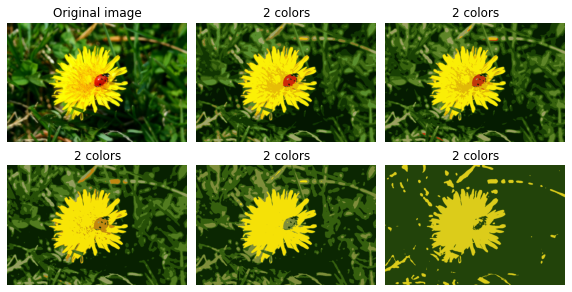

In [ ]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_cluster in enumerate(n_colors):
  plt.subplot(232 + idx)
  plt.imshow(segmented_imgs[idx])
  plt.title("{} colors".format(n_clusters))
  plt.axis('off')

plt.show()

컬러 클러스터의 수가 많을수록 색상 보존이 잘 이루어진다.